In [1]:
## A. Pendleton
## 2018-04-06
## Processing the final XP-CLR windows which have been shuffled 1000 times. 
## Enrichments through TopGO will be completed for each permutation and then we'll see what the enrichments are
## P-values are calculated as number of times a permuted p-value from TopGO was observed less than observed 
##       from our real data
## This data was given to Jeff to then calculate Q and FDR
## This script then takes his Q values and integrates the data into a summary Excel style table to become 
##       a Supplementary table, as well as a summary table with total statistics of GO categories at 
##       each filtration step

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import glob
import gzip
import fileinput
import time
import datetime
from scipy import stats

def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)

# Saving REAL GO enrichments 

In [3]:
################################################################################################################
def make_topgo_dict(totalTopGoFile):
    outputs = ['Observed_Total_GeneCounts_%s_BP.txt' % stat,'Observed_Total_GeneCounts_%s_CC.txt' % stat,'Observed_Total_GeneCounts_%s_MF.txt' % stat]
    topgoDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
    topGODict={}

    for output in outputs:
        inFile = topgoDir + output
        for line in open(inFile,'r'):
            line=line.rstrip().split('\t')
            if 'GO:' not in line[1]:
                continue
            GOID = line[1]
            topGODict[GOID] = line
    print('%i enriched gene categories added to topGoDict' % len(topGODict))
    return topGODict
################################################################################################################
def get_full_BLASTGO_category_names():
    #print ('#I downloaded ALL GO ontology categories from the geneontology.org website from the link:')
    #print ('http://purl.obolibrary.org/obo/go.obo')
    b2goDir = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/'
    fullGONameDatabase = b2goDir + 'Full_GO_Ontology_Database.obo'
    nameDict = {}
    for line in open(fullGONameDatabase,'r'):
        line=line.rstrip()
        if 'id:' in line:
            line = line.replace('id: ','')
            GOID = line
            nameDict[GOID] = ''
        if 'name:' in line:
            line = line.replace('name: ','')
            goName = line
            nameDict[GOID] = goName
    print('%i GO categories added to full name dictionary' % len(nameDict.keys()))       
    return nameDict
################################################################################################################
geneTable = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/BLAST2GO_GeneTables_WithEnscafIDsAndChrom.txt'
#Saving gene-protein links that were processed with BLAST2GO to array
TotEnsGene = {}

for line in open(geneTable,'r'):
    line = line.rstrip().split()
    ensG,ensP,chrom,start,end,geneName = line[1],line[0],line[5],line[6],line[7],line[8]
    TotEnsGene[ensG] = [ensG,ensP,chrom,start,end,geneName]
print ('\n%i genes read into gene-protein ID array' % len(TotEnsGene))

nameDict = get_full_BLASTGO_category_names()


19856 genes read into gene-protein ID array
49395 GO categories added to full name dictionary


# Processing permutations of random gene shuffles
# And writing respective topGO scripts for each

In [4]:
########################################################################################
def do_window_intersects(a,b,windowSize,outfile):
    cmd = 'bedtools window -w %i -a %s -b %s > %s' % (windowSize, a, b, outfile)
    #print(cmd)
    runCMD(cmd)
########################################################################################################
def parse_shuffle_intersect(Dict,intfile,linelength): 
    intersectFile = open(intfile,'r') #outfile from the intersect step with ensembl 81 genes
    ensID = ''
    sigGenes = [] #To keep track of all gene IDs (ENSCAFG) that are in sig windows
    geneLengths = [] #keeping track of gene lengths
    
    #Reading the intersect file results
    for line in intersectFile:
        line = line.rstrip() #removing extraneous whitespace characters
        line = line.split('\t') #delimiting "columns" in the file based on tabs		
        winID = line[3]
        
        if '_' in line[linelength+3]: #hit column
            hit = line[linelength+3].split('_')
            Protein = hit[0]
            Gene = hit[1]
            b2goID = Gene + '|' + Protein
            ensGID = hit[2]
        else:
            ensGID = line[linelength+3]
        if winID in Dict.keys():
            Dict[winID].append(ensGID)
        else:
            Dict[winID] = []
            Dict[winID].append(ensGID) 
        if b2goID not in sigGenes: 
            sigGenes.append(b2goID)
            geneLength = int(line[linelength+2]) - int(line[linelength+1])
            geneLengths.append(geneLength)
    intersectFile.close()  
    
    return Dict, sigGenes, geneLengths

# XPCLR - SHUFFLING PERMUTATIONS

In [6]:
#Write all xpclr sweeps to a output bedfile to be shuffled below
outDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/'
# OLD - NO HP FILTRATION === xpclrBedFile = outDir + '1Window_FinalXP-CLR_Windows.4.bed'
xpclrBedFile = outDir + '1Window_FinalXP-CLR_HpFiltered_DeltaHpFiltered_Windows.4.bed'
canFamGenome = '/home/ampend/links/kidd-lab/ampend-projects/cfERVs/GenePermutations/input/Cf3_AutosomesOnly.genome'
#gapBed = '/home/ampend/links/kidd-lab/ampend-projects/cfERVs/GenePermutations/input/CF3_gaps.bed'

for line in open(xpclrBedFile,'r'): #Determine what column intersect hits would be in
    linelength=len(line.rstrip().split())
    break

#Do 1000 bedtools shuffles WITHOUT regard to gaps
windowHitCounts, geneHitCounts  = [], []
total_geneLengths, perm_averageGeneLengths = [], []
for i in range(0,10000):
    #Shuffle the coordinates
    shuffledFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/permutations/shuffle_%i.txt' % (i)
    cmd = 'bedtools shuffle -i %s -g %s > %s' % (xpclrBedFile,canFamGenome, shuffledFile)
    runCMD(cmd)

    #Intersect with Ensembl gene models
    windowSize = int(50000)
    genebedfile = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/BLAST2GO_Ensembl81_GeneTables_WithEnscafIDsAndChrom.bed'
    outFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/permutations/intersect_ensembl_50kb_%i.txt' % (i)
    do_window_intersects(shuffledFile,genebedfile,int(windowSize),outFile)
    
    #Parse the intersect file with Ensembl genes from above
    ensGDict = {}
    ensGDict,sigGenes,geneLengths = parse_shuffle_intersect(ensGDict,outFile,linelength)
    
    ##Write the B2GO IDs to an output file for subsequent TopGO enrichments
    topGOGeneFile = open('/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/permutations/ensemblGeneIDs_50kb_%i.txt' % i,'w')
    for g in sigGenes:
        topGOGeneFile.write('%s\n' % g)
    topGOGeneFile.close()
    
    ##Keeping track of gene lengths and how many windows have genes
    windowHitCounts.append(len(ensGDict.keys())) #How many sweeps intersect with at least one gene
    geneHitCounts.append(len(sigGenes)) #How many genes are within 50kb
    for k in geneLengths:
        total_geneLengths.append(k)
    perm_averageGeneLengths.append(np.mean(geneLengths))
    #break

### TopGO Script for permutations

In [5]:
#Defining the paths to necessary files for the topGO scripts
topgoDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
inputDir = topgoDir + 'input/'
outDir = topgoDir + 'results/'

#geneIDTotalFile = inputDir + 'Input_TOPGO_17860AnnotatedGenes.txt'
geneIDTotalFile = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/Input_TOPGO_AnnotatedGenes_NOchrX_NOchrM_NOchrUn.txt'


categories = ['BP','CC','MF']
stats = ['Weight01','Elim','ParentChild']
outDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/results/'

for stat in stats:
    for perm in range(0,10000):
        topGoScript = open(topgoDir + 'scripts/' + 'topgo_permutation_%i_%s.R' % (perm,stat), 'w')
        inputGeneFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/permutations/ensemblGeneIDs_50kb_%i.txt' % perm
        
        topGoScript.write('#1. Initiating topGO\n')
        topGoScript.write('library("topGO")\n\n')

        topGoScript.write('#2. Reading in the .annot file in proper format for TopGO that I generated.\n')
        topGoScript.write('#This contains the information for 17,860 annotated genes from BLAST2GO\n')
        topGoScript.write('geneID2GO <- readMappings(file = "%s")\n' % geneIDTotalFile)  
        topGoScript.write('geneUniverse <- names(geneID2GO)\n\n')

        topGoScript.write('#3. Read in a list of interesting genes from a file\n')
        topGoScript.write('#File format = list of gene IDs, one per line\n')
        topGoScript.write('genesOfInterest <- read.table("%s",header=FALSE)\n' % inputGeneFile)
        topGoScript.write('genesOfInterest <- as.character(genesOfInterest$V1)\n')
        topGoScript.write('geneList <- factor(as.integer(geneUniverse %in% genesOfInterest))\n')
        topGoScript.write('names(geneList) <- geneUniverse\n\n')

        for category in categories:
            topGoScript.write('##CATEGORY %s\n' % category)
            topGoScript.write('#4. build the GOdata object in topGO\n')
            topGoScript.write('myGOdata <- new("topGOdata", description="1Window_Final_XP-CLR", ontology="%s", allGenes=geneList,  annot = annFUN.gene2GO, gene2GO = geneID2GO)\n\n' % category)

            topGoScript.write('#5. run the Fisher\'s exact tests in different ways...\n')
            topGoScript.write('resultClassic <- runTest(myGOdata, algorithm="classic", statistic="fisher")\n')
            topGoScript.write('resultElim <- runTest(myGOdata, algorithm="elim", statistic="fisher")\n')
            topGoScript.write('resultWeight01 <- runTest(myGOdata, algorithm="weight01", statistic="fisher")\n')
            topGoScript.write('resultParentChild <- runTest(myGOdata, algorithm="parentchild", statistic="fisher")\n\n')
            topGoScript.write('numGOTotal = length(usedGO(object = myGOdata)) \n')

            topGoScript.write('#6. Write TOTAL file out\n')
            total_outputFile = outDir + 'TopGO_%s_%s_TOTAL_%i.txt' % (category,stat,perm)                  
            topGoScript.write('tab.All <- GenTable(myGOdata, %s = result%s, topNodes = numGOTotal)\n' % (stat,stat))
            topGoScript.write('write.table(tab.All,\'%s\',quote=FALSE,sep=\'\t\')\n' % total_outputFile)    

            """topGoScript.write('#7b. See how many results we get where weight01 gives a P-value <= 0.05:\n')
            topGoScript.write('#%s\n' % stat)
            topGoScript.write('#AT 0.05\n')
            topGoScript.write('mysummary <- summary(attributes(result%s)$score <= 0.05)\n' % stat)
            topGoScript.write('numsignif <- as.integer(mysummary[[3]]) # how many terms is it true that P <= 0.05\n')
            topGoScript.write('#Putting together those that were sig\n')
            topGoScript.write('allRes <- GenTable(myGOdata, classicFisher = resultClassic, elimFisher = resultElim, weight01Fisher = resultWeight01, parentchildFisher = resultParentChild, orderBy = "parentchildFisher", ranksOf = "classicFisher", topNodes = numsignif)\n\n')
                        
            outputFile = outDir + 'TopGO_%s_%s_p05_%i.txt' % (stat,category,perm)                  
            topGoScript.write('#Write table of significant %s GO terms in file below:\n' % stat)
            topGoScript.write('output_file05 = \'%s\' \n' % outputFile)
            topGoScript.write('write.table(x = allRes, file = output_file05, quote=FALSE, sep = "\t")\n\n')

            topGoScript.write('#8b. Print out the genes that are annotated with the significantly enriched GO terms:\n')
            topGoScript.write('myterms <- allRes$GO.ID\n')
            topGoScript.write('mygenes <- genesInTerm(myGOdata, myterms)\n')

            outputFile2 = outDir + 'TopGO_%s_%s_p05_%i_genes.txt' % (stat,category,perm)                  
            topGoScript.write('output_file05_2 = \'%s\' \n\n' % outputFile2)

            topGoScript.write('for (i in 1:length(myterms))\n')
            topGoScript.write('{\n')
            topGoScript.write('\tmyterm <- myterms[i]\n')
            topGoScript.write('\tmygenesforterm <- mygenes[myterm][[1]]\n')
            topGoScript.write('\tmyfactor <- mygenesforterm %in% genesOfInterest # find the genes that are in the list of genes of interest\n')
            topGoScript.write('\tmygenesforterm2 <- mygenesforterm[myfactor == TRUE] \n')
            topGoScript.write('\tmygenesforterm2 <- paste(mygenesforterm2, collapse=\',\')\n')
            topGoScript.write('\tprint(paste(myterm,mygenesforterm2))\n')
            topGoScript.write('\tnewline = paste(myterm,mygenesforterm2)\n')
            topGoScript.write('\twrite.table(newline, file = output_file05_2, row.names =    FALSE, append = TRUE, col.names = FALSE)\n')
            topGoScript.write('}\n\n')
            """
        topGoScript.close()

#SAVING COMMANDS TO OUTFILE
topgoDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
stats = ['Weight01','Elim','ParentChild']
cmdsFile = open(topgoDir + 'scripts/' + 'topGo.cmds', 'w')
for stat in stats:
    for perm in range(0,10000):
        cmdsFile.write('Rscript %sscripts/topgo_permutation_%i_%s.R\n' % (topgoDir, perm,stat))
cmdsFile.close()
    

# Saving permutation enrichments to dictionary
# to compare with real enrichment data
# #**P-VALUES**#

In [5]:
def check_real_data(topGODict,permPDict,permGeneCountDict,nameDict,outFile):
    nonZeroCategoryCount = 0
    all_pvalues,nonZeroCounts_pvalues,medianFiltered_pvalues,pDict = [], [], [], {}
    sigCategories, nonZeroCounts_sigCategories = [], []
    passes = {}
    totalEnrichments,nonZeroCounts_totalEnrichments = [], []

    outFile.write('GO ID\tGO Description\tGene Count in Genome\tGene Count in Observed\tAvg Gene Count in Permutations\tFold Enrichment\tObserved P-value\tAvg Perm P-value\tMedian Perm P-Value\tMin Perm P-Value\tMax Perm P-value\tSimulation Informed P-value (# Lower than Obs P/1000)\n')

    for key in topGODict.keys():
        if key not in permPDict.keys():
            continue
        obs_count = int(topGODict[key][4]) #how many observed in REAL XP-CLR data
        obs_pvalue = float(topGODict[key][6]) #how many observed in REAL XP-CLR data
        higherThanObsCount = 0 #to keep track of permuted gene counts higher than observed
        lowerThanObsP = 0 #keep track of permuted pvalues lower than observed
        
        #COUNTS ---- Go through all permutation counts and see if it's higher than the observed
        """for perm_count in permGeneCountDict[key]:
            if perm_count >= obs_count:
                higherThanObsCount += 1"""
        avgPermCounts = np.mean(permGeneCountDict[key])
        #print('avgPermCounts',avgPermCounts)
        
        #PVALUE ---- Go through all permutation counts and see if it's *LOWER* than the observed 
        for pvalue in permPDict[key]:
            if pvalue <= obs_pvalue:
                lowerThanObsP += 1
        avgPermP = np.mean(permPDict[key])
        medianPermP = np.median(permPDict[key])
        minPermP = min(permPDict[key])
        maxPermP = max(permPDict[key])
        
        #Rate *or p-value* is the number of times the permutatino was <= observed pvalue
        #         divided by permutation count (here = 1000)
        rate = float((lowerThanObsP + 1)/(len(permPDict[key])+1)) # rate = perm p-value
        pvalues.append(rate) # rate = perm p-value
        pDict[key] = rate # rate = perm p-value

        #Enrichment = average of observations
        totalEnrichments.append([rate,(obs_count/np.mean(permGeneCountDict[key])),key])
        
        #Keep track of all p-values
        all_pvalues.append(rate) 
        
        #Now keeping track of the categories that have more than one XP-CLR gene in them
        if obs_count > 0:
            nonZeroCategoryCount += 1
            if minPermP != 1.0:
                nonZeroCounts_pvalues.append(rate)
                if medianPermP != 1.0:
                    medianFiltered_pvalues.append(rate)
            nonZeroCounts_totalEnrichments.append([rate,(obs_count/np.mean(permGeneCountDict[key])),key])

        #SUMMARY OUTFILE
        if key in nameDict.keys():
            fullName = nameDict[key]
        else:
            fullName = topGODict[key][2]

        outFile.write('%s\t%s\t%s\t%i\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\n' % (key,fullName,topGODict[key][3],obs_count,avgPermCounts,obs_count/avgPermCounts,obs_pvalue,avgPermP,medianPermP,minPermP,maxPermP,rate))       
    #outFile.close()
    return all_pvalues, nonZeroCounts_pvalues, nonZeroCounts_totalEnrichments, medianFiltered_pvalues


# Process outputs from TOPGO

## Parent-Child

#### REAL DATA
19958 enriched gene categories added to topGoDict
49395 GO categories added to full name dictionary


#### PERMUTED DATA


#BP	ParentChild


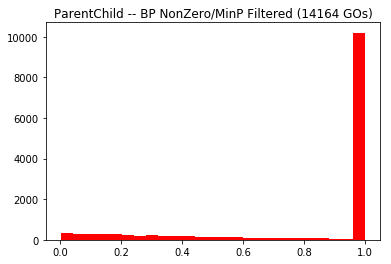

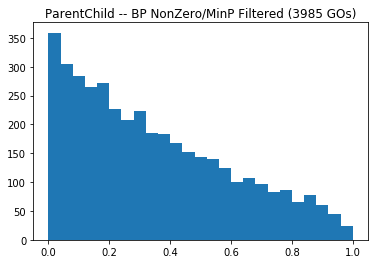

1000 permutations added for processing
14164 GO IDs added to permutation count dictionary
14164 GO IDs added to permutation p-value dictionary


#CC	ParentChild


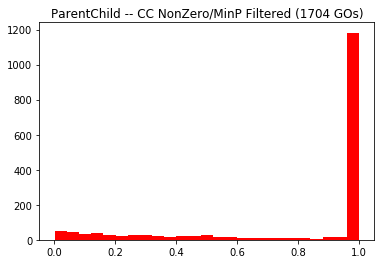

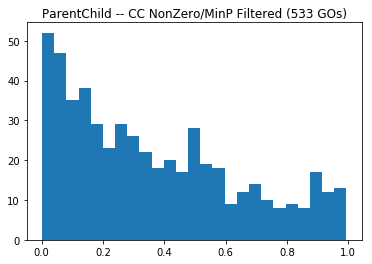

1000 permutations added for processing
1704 GO IDs added to permutation count dictionary
1704 GO IDs added to permutation p-value dictionary


#MF	ParentChild


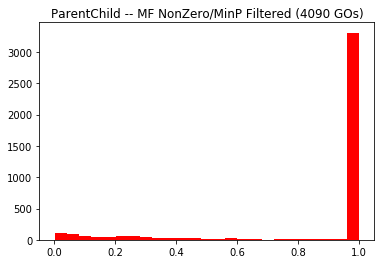

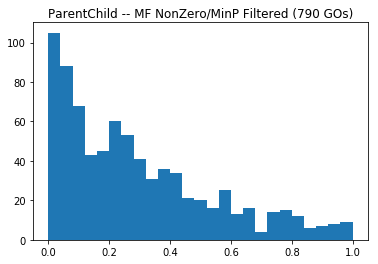

1000 permutations added for processing
4090 GO IDs added to permutation count dictionary
4090 GO IDs added to permutation p-value dictionary


In [12]:
# REAL DATA
print('#### REAL DATA')
#*********
#Which stat output are you processing    #stat = 'Elim'  #stat = 'ParentChild' or #stat = 'Weight01'
#stat = 'Weight01'
#stat = 'Elim'
stat = 'ParentChild'
#*********

topGoDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
mergedOutFile =topGoDir + 'Merged_1Window_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_TopGOOutput_%s_Genes_BP_MF_CC.txt' % stat

topGODict = make_topgo_dict(mergedOutFile)

nameDict = get_full_BLASTGO_category_names()

############################################################################################################
# PERMUTED DATA

print('\n\n#### PERMUTED DATA')
categories = ['BP','CC','MF']

inDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/results/' 
outDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
pValuesTotal,nonZero_pValuesTotal = [], []

for category in categories:
    permGeneCountDict,permPDict = {}, {} #Clear variables per category
    outFile = open(outDir + 'SummaryTable_TopGO_%s_%s.txt' % (stat,category), 'w') #Make outfile JUST for the category
    perms,pvalues = [],[]
    
    for perm in range(0,1000):
        perms.append(perm)
        infile = inDir + 'TopGO_%s_%s_TOTAL_%i.txt' % (category, stat, perm)

        for line in open(infile,'r'):
            line=line.rstrip().split('\t')
            if 'GO.ID' in line[0]: # skip header
                continue
            GOcat = line[1]
            #Keep track of counts
            observedCount = int(line[4])
            if GOcat not in permGeneCountDict.keys():
                permGeneCountDict[GOcat] = []          
            permGeneCountDict[GOcat].append(observedCount)
            
            #Keep track of pvalues
            if '< ' in line[6]:
                pvalue = float('1e-30')
                continue
            else:
                pvalue = float(line[6])
            if GOcat not in permPDict.keys():
                permPDict[GOcat] = []
            permPDict[GOcat].append(pvalue)

    pValuesTotal.append(pvalues) #Keeping track of ALL pvalues, regardless of gene count
    #Generate summary file by checking what each GO term looks like in real vs permuted data
    all_pvalues,nonZeroCounts_pvalues, nonZeroCounts_totalEnrichments, medianFiltered_pvalues = check_real_data(topGODict,permPDict,permGeneCountDict,nameDict,outFile)
    outFile.close()
            
    print('\n\n#%s\t%s' % (category, stat))
    plt.hist(all_pvalues,25,facecolor='red')
    plt.title('%s -- %s NonZero/MinP Filtered (%i GOs)' % (stat,category,len(all_pvalues)))
    plt.show()
    
    plt.hist(nonZeroCounts_pvalues,25)
    plt.title('%s -- %s NonZero/MinP Filtered (%i GOs)' % (stat,category,len(nonZeroCounts_pvalues)))
    plt.show()
    
    print('%i permutations added for processing' % len(perms))
    print('%i GO IDs added to permutation count dictionary' % len(permGeneCountDict.keys()))
    print('%i GO IDs added to permutation p-value dictionary' % len(permPDict.keys()))
      
    

# On your own, you must run the following steps for each STAT (parent-child,elim,weight01):
1. python /home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/parse_scripts/filter-files-STAT.py
2. Download on to your computer
3. Run the following script: Qvalue-STAT.R
4. Upload the resulting qvalue tables per category (BP,CC,MF) back to Flux
5. THEN process the steps below
    

# What categories are significant after permutations?

In [9]:
xpGeneDict = {}

geneIntersectFileXPCLR = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/1Window_Intersect_With_Ensembl81Genes_50kbWindow.txt'

for line in open(geneIntersectFileXPCLR,'r'):
    line=line.rstrip().split('\t')
    XPCLR = line[3]
    gene = line[12]
    ensG,geneName = gene.split('_')[1],gene.split('_')[2]
    if ensG not in xpGeneDict.keys():
        xpGeneDict[ensG] = []
    #xpGeneDict[ensG].append([XPCLR,ensG,geneName,IDs])
    #xpGeneDict[ensG].append([XPCLR,ensG,geneName])
    xpGeneDict[ensG].append(XPCLR)
print('Added %i genes intersecting with XP-CLR regions to xpGeneDict' % len(xpGeneDict.keys()))


Added 429 genes intersecting with XP-CLR regions to xpGeneDict


In [10]:
def get_permDict(inDir,categories):
    permDict = {}
    for category in categories:
        permFile = inDir + 'SummaryTable_TopGO_%s_%s.txt' % (stat,category)

        for line in open(permFile, 'r'):
            line=line.rstrip().split('\t')
            if 'Description' in line[1]: #skip header 
                continue
            permDict[line[0]] = line
    
    return permDict
#########################################################################################################
def create_xpGeneDict():
    xpGeneDict = {}

    geneIntersectFileXPCLR = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/1Window_Intersect_With_Ensembl81Genes_50kbWindow.txt'

    for line in open(geneIntersectFileXPCLR,'r'):
        line=line.rstrip().split('\t')
        XPCLR = line[3]
        gene = line[12]
        ensG,geneName = gene.split('_')[1],gene.split('_')[2]
        if ensG not in xpGeneDict.keys():
            xpGeneDict[ensG] = []
        #xpGeneDict[ensG].append([XPCLR,ensG,geneName,IDs])
        xpGeneDict[ensG].append([XPCLR,ensG,geneName])

    print('Added %i genes intersecting with XP-CLR regions to xpGeneDict' % len(xpGeneDict.keys()))
    return xpGeneDict
#########################################################################################################
def create_GOGeneDict(stat,categories):
    #goGeneFile = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/Input_TOPGO_AnnotatedGenes_NOchrX_NOchrM_NOchrUn.txt'
    geneGODict = {} #All canfam genes and the categories they are in
    categories = ['BP','CC','MF']

    GOgeneDict = {}
    for category in categories:
        inDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
        goGeneFile = inDir + 'Observed_Total_GeneCounts_%s_%s_Genes.txt' % (stat,category)
        for line in open(goGeneFile,'r'):
            line=line.replace('"','')
            line = line.rstrip().split()
            if len(line) < 2: #Some categories have no genes, because they aren't in dog
                continue
            ID = line[0]
            genes = line[1].split(',')
            for gene in genes:
                ensG = gene.split('|')[0]
                #Save with GO as key
                if ID not in GOgeneDict.keys():
                    GOgeneDict[ID] = []
                GOgeneDict[ID].append(ensG)
                #Save with EnsG as key
                if ensG not in geneGODict.keys():
                    geneGODict[ensG] = []
                geneGODict[ensG].append(ID)

    print('%i GO-Gene connections added' % (len(GOgeneDict.keys())))
    return geneGODict,GOgeneDict
#########################################################################################################
def get_ensembl_IDs(GOID):
    genes = []
    for ID in GOgeneDict.keys():
        if ID != GOID:
            continue
        for gene in GOgeneDict[ID]:
            if gene in xpGeneDict.keys() and gene not in genes:
                genes.append(gene)
    GENES = ', '.join(genes)
    geneCount=len(genes)
    return GENES,geneCount
#########################################################################################################
def get_gene_names(genes):
    GENES = genes.split(', ')
    geneNames = []
    for gene in GENES:
        geneName = TotEnsGene[gene][5]
        geneNames.append(geneName)
    geneNames = ', '.join(geneNames)
    return geneNames
#########################################################################################################

geneTable = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/BLAST2GO_GeneTables_WithEnscafIDsAndChrom.txt'
#Saving gene-protein links that were processed with BLAST2GO to array
TotEnsGene = {}

for line in open(geneTable,'r'):
    line = line.rstrip().split()
    ensG,ensP,chrom,start,end,geneName = line[1],line[0],line[5],line[6],line[7],line[8]
    TotEnsGene[ensG] = [ensG,ensP,chrom,start,end,geneName]
print ('\n%i genes read into gene-protein ID array' % len(TotEnsGene))



19856 genes read into gene-protein ID array


In [11]:
inDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
categories = ['BP','CC','MF']

xpGeneDict = create_xpGeneDict()
stat = 'ParentChild'

#Save permutation information to dictionary
permDict = get_permDict(inDir,categories)

sigDict,permHits = {}, {}

#Get gene/GO/XP-CLR dictionaries
geneGODict,GOgeneDict = create_GOGeneDict(stat,categories)

print('### %s' % stat)
SIG = []
for category in categories:
    sig, notOneXPCount, genomeCountGreaterThan1, xpGeneCountGreaterThan1 = [], 0, 0, 0
    print('# %s' % category)
    inFile = inDir + '%s.%s.qvals.txt' % (category,stat)
    for line in open(inFile,'r'):
        line=line.rstrip().split()
        if 'V1' in line[0]: #skip header
            continue

        GOID, pvalue, qvalue = line[1], float(line[4]), float(line[5])

        if pvalue >= 0.05: #skip those that aren't significant
            continue
        sig.append(GOID) #This means these are significant

        #Now, determine what the observed/permutation stats were
        desc,genomeCount,obsCount,obsP = topGODict[GOID][2],topGODict[GOID][3],topGODict[GOID][4],topGODict[GOID][6]
        if GOID in nameDict.keys():
            desc = nameDict[GOID]
        permP = permDict[GOID][11] #rate from above (# < obs P + 1 / 1000 + 1)
        minP,maxP,avgP = float(permDict[GOID][8]),float(permDict[GOID][9]),float(permDict[GOID][10])
        avgPermGeneCount, enrichment = float(permDict[GOID][4]), float(permDict[GOID][5])

        #Get XP-CLR Region
        xpclrs = []
        if GOID not in GOgeneDict.keys():
            missingGO.append(GOID)
            continue
        for key in GOgeneDict[GOID]:
            if key in xpGeneDict.keys():
                 for i in range(0,len(xpGeneDict[key])):
                    xp = xpGeneDict[key][i][0]
                    if xp not in xpclrs:
                        xpclrs.append(xp)
        XPCLRS = ', '.join(xpclrs)
        uniqueXPCLRs = len(set(xpclrs))
        permHits[GOID] = [category]
        
        if int(genomeCount) > 1:
            genomeCountGreaterThan1 += 1
            #Must be in more than one XP-CLR and cannot be observed once in genome to begin with
            if uniqueXPCLRs > 1: 
                notOneXPCount += 1
                #Find the ensembl IDs in those loci
                genes,geneCount = get_ensembl_IDs(GOID)
                
                geneNames = get_gene_names(genes)
                #Must be represented by more than one gene (a long gene can span multiple XP-CLRs)
                if geneCount > 1:
                    xpGeneCountGreaterThan1 += 1
                    #SAVE INTO DICTIONARY
                    if GOID in sigDict.keys():
                        sigDict[GOID][0] = sigDict[GOID][0] + '/%s' % category
                    else:
                        sigDict[GOID] = [category,GOID,desc,genomeCount,obsCount,avgPermGeneCount,enrichment,obsP,qvalue,permP,XPCLRS,uniqueXPCLRs,genes,geneNames,geneCount]

    print('%i significant GO terms found for %s' % (len(sig),stat))
    print('%i signifcant GO terms had genome gene Count > 1' % (genomeCountGreaterThan1))
    print('%i significant GO terms with more than one XP-CLR locus' % notOneXPCount)
    print('%i significantGO terms had XP-CLR gene count > 1' % xpGeneCountGreaterThan1)
    print('FINAL sig %s = %i' % (category,xpGeneCountGreaterThan1 ))
    for s in sig:
        SIG.append(s)
#Now write out
outFile = open(inDir + 'SIGONLY_SummaryTable_TopGO_%s_BP_MF_CC.txt' % (stat), 'w')
header = ['GO category','GO ID','GO Description','Genes In Genome','Gene Count Observed in XP-CLR Set','Average Gene Count Observed in Permutations','Fold Enrichment (Observed Count/Average Permuted Count)','Raw Parent-Child TopGO P-Value','Q-value','Permuted P (Number of Permutations < Observed P Value +1 / Permutation Rounds + 1)','XP-CLR Loci With Genes in Category','Number of XP-CLR Loci','Ensembl IDs in XP-CLR loci','Genes in XP-CLR Loci','Number of genes']
outFile.write("\t".join(map(str,header))+'\n')
for keys in sigDict.keys(): #Now loops through each 
    outFile.write("\t".join(map(str,sigDict[keys])))
    outFile.write("\n")
outFile.close()
   
    

Added 429 genes intersecting with XP-CLR regions to xpGeneDict
5380 GO-Gene connections added
### ParentChild
# BP
431 significant GO terms found for ParentChild
352 signifcant GO terms had genome gene Count > 1
232 significant GO terms with more than one XP-CLR locus
225 significantGO terms had XP-CLR gene count > 1
FINAL sig BP = 225
# CC
71 significant GO terms found for ParentChild
65 signifcant GO terms had genome gene Count > 1
52 significant GO terms with more than one XP-CLR locus
52 significantGO terms had XP-CLR gene count > 1
FINAL sig CC = 52
# MF
134 significant GO terms found for ParentChild
99 signifcant GO terms had genome gene Count > 1
51 significant GO terms with more than one XP-CLR locus
50 significantGO terms had XP-CLR gene count > 1
FINAL sig MF = 50


## Compare Non-Permuted vs Permuted Enriched GO Category Sets

In [19]:
#Get GO-Category associations
goCats = {}
stat = 'ParentChild'

inDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'

for category in categories:
    inFile = inDir + 'SummaryTable_TopGO_%s_%s.txt' % (stat,category)
    for line in open(inFile,'r'):
        line=line.rstrip().split('\t')
        if 'GO ID' in line[0]: #skip header
            continue
        GOID = line[1]
        if GOID in goCats.keys():
            CAT = goCats[GOID] + '/' + category
        else:
            CAT = category
        goCats[GOID] = CAT
print('%i GO IDs added to dictionary' % len(goCats.keys()))

19955 GO IDs added to dictionary


#### OBSERVED - Raw - NON-PERMUTED:


In [20]:
### OBSERVED - Raw - NON-PERMUTED:
stat = 'ParentChild'

inDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
rawCats = {}
for category in categories:
    inFile = inDir + 'Observed_Total_GeneCounts_%s_%s.txt' % (stat,category)
    for line in open(inFile,'r'):
        line=line.rstrip().split('\t')
        if 'GO.ID' in line[0]: #skip header
            continue
        GOID = line[1]
        pvalue = float(line[6])
        if pvalue >= 0.05: #We only want significant
            continue
        #What XP-CLR loci represent these genes?
        #Get XP-CLR Region
        xpclrs = []
        if GOID not in GOgeneDict.keys():
            missingGO.append(GOID)
            continue
        for key in GOgeneDict[GOID]:
            if key in xpGeneDict.keys():
                 for i in xpGeneDict[key]:
                    xpclrs.append(i[0])
        XPCLRS = ', '.join(xpclrs)
        uniqueXPCLRs = len(set(xpclrs))
        #What XP-CLR genes are in GOID? 
        genes,geneCount = get_ensembl_IDs(GOID)
        if geneCount == 1:
            continue
        rawCats[GOID] = []
        rawCats[GOID] = [GOID,category,geneCount,uniqueXPCLRs]

print('%i significant raw,unpermuted categories' % len(rawCats))


204 significant raw,unpermuted categories


### Comparisons


In [21]:
compareList = []
both,raw,permuted = 0,0,0
both2,raw2,permuted2 = 0,0,0
rawOver2Total = 0

for GOID in rawCats.keys():
    if GOID in SIG: #If in the total, nonxpclr count required sig hits
        compareList.append([GOID,'Both'])
        both+=1
        if int(rawCats[GOID][3]) > 1:
            both2 +=1
    else:
        compareList.append([GOID,'Raw'])
        raw+=1
        if int(rawCats[GOID][3]) > 1:
            raw2 +=1
    #GET TOTAL NUMBER OF RAW WITH XPCLR COUNTS > 1
    if int(rawCats[GOID][3]) > 1:
        rawOver2Total += 1

permOver2Total = len(sigDict.keys())
for GOID in SIG:
    if GOID not in rawCats.keys():
        compareList.append([GOID,'Permuted'])
        permuted+=1
        if GOID in sigDict.keys():
            permuted2 += 1
            
print('%i sig TOTAL raw categories' % len(rawCats.keys()))
print('%i sig TOTAL permuted categories\n' % len(permHits.keys()))

print('%i categories only found in raw parent-child topgo set' % raw)
print('%i categories only found in permuted set' % permuted)
print('%i categories found in both sets\n' % both)

print('%i categories with >2 in RAW' % rawOver2Total)
print('%i categories with >2 in PERMUTED\n' % permOver2Total) 

print('%i categories only found in raw parent-child topgo -- 2 or more XP-CLR' % raw2)
print('%i categories only found in permuted set -- 2 or more XP-CLR' % permuted2)
print('%i categories found in both sets -- 2 or more XP-CLR' % both2)



204 sig TOTAL raw categories
636 sig TOTAL permuted categories

14 categories only found in raw parent-child topgo set
446 categories only found in permuted set
190 categories found in both sets

201 categories with >2 in RAW
327 categories with >2 in PERMUTED

14 categories only found in raw parent-child topgo -- 2 or more XP-CLR
140 categories only found in permuted set -- 2 or more XP-CLR
187 categories found in both sets -- 2 or more XP-CLR


In [42]:
from matplotlib_venn import venn2, venn2_circles


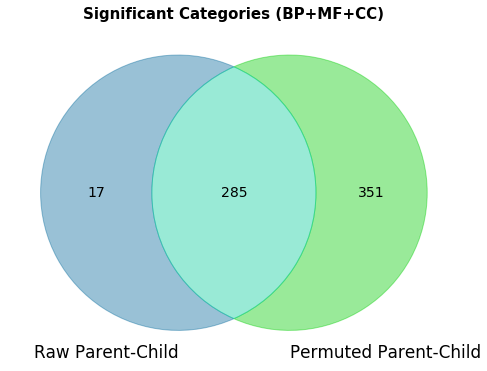

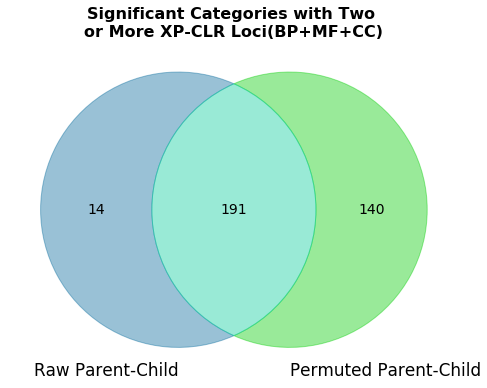

In [53]:
font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
#######################################
plt.figure(figsize=(8,8))
s = (1,1,1)
c = venn2(subsets = s, set_labels = ('Raw Parent-Child','Permuted Parent-Child'))
c.get_label_by_id('10').set_text(raw)
c.get_patch_by_id('10').set_color('#006699')
c.get_label_by_id('11').set_text(both)
c.get_patch_by_id('11').set_color('#00cc99')
c.get_label_by_id('01').set_text(permuted)
c.get_patch_by_id('01').set_color('#00cc00')
plt.title("Significant Categories (BP+MF+CC)",fontsize=15,fontweight="bold")
plt.show()
###########################################

plt.figure(figsize=(8,8))
s = (1,1,1)
c = venn2(subsets = s, set_labels = ('Raw Parent-Child','Permuted Parent-Child'))
c.get_label_by_id('10').set_text(raw2)
c.get_patch_by_id('10').set_color('#006699')
c.get_label_by_id('11').set_text(both2)
c.get_patch_by_id('11').set_color('#00cc99')
c.get_label_by_id('01').set_text(permuted2)
c.get_patch_by_id('01').set_color('#00cc00')
plt.title("Significant Categories with Two \nor More XP-CLR Loci(BP+MF+CC)",fontsize=16,fontweight="bold")
plt.show()

In [22]:
### OBSERVED - Raw - NON-PERMUTED:
stat = 'ParentChild'

inDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
permCats = []
inFile = inDir + 'SIGONLY_SummaryTable_TopGO_%s_BP_MF_CC.txt' % (stat)
for line in open(inFile,'r'):
    line=line.rstrip().split('\t')
    if 'Enrich' in line: #skip header
        continue
    GOID = line[1]
    permCats.append(GOID)
print('%i significant raw,unpermuted categories' % len(permCats))



328 significant raw,unpermuted categories


# SEARCHING FOR MANUSCRIPT WRITING

In [23]:
xrankFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/final-xpclr-formanuscript-ranks.txt'
xrankDict = {}

for line in open(xrankFile,'r'):
    if 'Window' in line:
        continue
    line=line.rstrip().split()
    xrankDict[line[0]] = int(line[3])
print('Added %i xpclr loci with ranks to dictionary' % len(xrankDict.keys()))


Added 246 xpclr loci with ranks to dictionary


### SEARCH = GO description
#### Provides GOs, genes, and XP-CLR loci with GO description keyword 


In [32]:
keyword = 'palate'

for ID in nameDict.keys():
    if ID not in GOgeneDict.keys():
        continue
    if keyword in nameDict[ID].lower():
        if float(permDict[ID][11]) < 0.05:
            print('\n#',ID, nameDict[ID],permDict[ID][11],'**********')
        else:
            print('\n#',ID, nameDict[ID],permDict[ID][11])
        for gene in GOgeneDict[ID]:
            print(TotEnsGene[gene][5],xpGeneDict[gene][0][0],'-- Rank #', xrankDict[xpGeneDict[gene][0][0]])


# GO:0060021 palate development 0.819181
SATB2 XP-CLR_244 -- Rank # 131


### Find GO terms that a given gene belongs to
#### Great for searching top-ranked XP-CLR loci genes


In [26]:
GeneOfInterest = 'BOLL'

for gene in xpGeneDict:
    for i in xpGeneDict[gene]:
        if GeneOfInterest in i[2]:
            print(xpGeneDict[gene])
            ensG = i[1]
            print('#',gene,ensG)
            for GO in geneGODict[ensG]:
                print(GO,nameDict[GO],permDict[GO][11])


[['XP-CLR_243', 'ENSCAFG00000010947', 'BOLL']]
# ENSCAFG00000010947 ENSCAFG00000010947
GO:0045727 positive regulation of translation 0.073926
GO:0006412 translation 0.055944
GO:0010628 positive regulation of gene expression 0.268731
GO:0045948 positive regulation of translational initiation 0.232767
GO:0008152 metabolic process 0.248751
GO:0006413 translational initiation 0.241758
GO:0006417 regulation of translation 0.113886
GO:0019222 regulation of metabolic process 0.284715
GO:0009891 positive regulation of biosynthetic process 0.312687
GO:0009893 positive regulation of metabolic process 0.800200
GO:0048522 positive regulation of cellular process 0.166833
GO:0048518 positive regulation of biological process 0.098901
GO:0009889 regulation of biosynthetic process 0.562438
GO:0010556 regulation of macromolecule biosynthetic process 0.526474
GO:0010557 positive regulation of macromolecule biosynthetic process 0.242757
GO:0032268 regulation of cellular protein metabolic process 0.895105


## Looking through the XP-CLR genes for genes of interest 

In [552]:
#Saving the Gene IDs from XP-CLR loci to an array
GOGENELIST = []
for gene in xpGeneDict.keys():
    if gene in GOGENELIST:
        continue
    GOGENELIST.append(TotEnsGene[gene][5])
print('Added the %i genes from XP-CLR loci to an array' % len(GOGENELIST))

Added the 429 genes from XP-CLR loci to an array


In [553]:
for xp in xpGeneDict.keys():
    print(xp)
    break

ENSCAFG00000028557


429


######## EXTRAS ALL BELOW THIS ############
# IGNORE

In [82]:
"""def check_real_data(topGODict,permPDict,permGeneCountDict,nameDict,outFile):
    nonZeroCategoryCount = 0
    pvalues,nonZeroCounts_pvalues,pDict = [], [], {}
    sigCategories, nonZeroCounts_sigCategories = [], []
    passes = {}
    totalEnrichments,nonZeroCounts_totalEnrichments = [], []

    #outFile.write('GO ID\tGO Description\tGene Count in Genome\tGene Count in Observed\tAvg Gene Count in Permutations\tFold Enrichment\tObserved P-value\tAvg Perm P-value\tMin Perm P-Value\tMax Perm P-value\tSimulation Informed P-value (# Lower than Obs P/1000)\tAll Permutation Observations Array\n')
    outFile.write('GO ID\tGO Description\tGene Count in Genome\tGene Count in Observed\tAvg Gene Count in Permutations\tFold Enrichment\tObserved P-value\tAvg Perm P-value\tMin Perm P-Value\tMax Perm P-value\tSimulation Informed P-value (# Lower than Obs P/1000)\n')

    for key in topGODict.keys():
        if key not in permPDict.keys():
            continue
        if 'GO:0032147' not in key:
            continue
        print(key)
        print(topGODict[key])
        obs_count = int(topGODict[key][4]) #how many observed in REAL XP-CLR data
        obs_pvalue = float(topGODict[key][6]) #how many observed in REAL XP-CLR data
        print('obs_count = ',obs_count)
        print('obs_pvalue = ',obs_pvalue)
        higherThanObsCount = 0 #to keep track of permuted gene counts higher than observed
        lowerThanObsP = 0 #keep track of permuted pvalues lower than observed
        
        #COUNTS ---- Go through all permutation counts and see if it's higher than the observed
        """for perm_count in permGeneCountDict[key]:
            if perm_count >= obs_count:
                higherThanObsCount += 1"""
        avgPermCounts = np.mean(permGeneCountDict[key])
        print('avgPermCounts',avgPermCounts)
        
        #PVALUE ---- Go through all permutation counts and see if it's *LOWER* than the observed 
        print('Smaller:')
        for pvalue in permPDict[key]:
            if pvalue <= obs_pvalue:
                lowerThanObsP += 1
                print(pvalue)
        avgPermP = np.mean(permPDict[key])
        minPermP = min(permPDict[key])
        maxPermP = max(permPDict[key])
        print('avgPermP,minPermP,maxPermP = ', avgPermP,minPermP,maxPermP)
        
        #Rate *or p-value* is the number of times the permutatino was <= observed pvalue
        #         divided by permutation count (here = 1000)
        rate = float((lowerThanObsP + 1)/(len(permPDict[key])+1)) # rate = perm p-value
        print('rate = float((lowerThanObsP + 1)/(len(permPDict[key])+1))')
        print('rate = float((%i + 1)/((%i)+1))' % (lowerThanObsP,len(permPDict[key])))
        print('rate = ', rate)
        pvalues.append(rate) # rate = perm p-value
        pDict[key] = rate # rate = perm p-value

        #Enrichment = average of observations
        totalEnrichments.append([rate,(obs_count/np.mean(permGeneCountDict[key])),key])
        
        #Now keeping track of the categories that have more than one XP-CLR gene in them
        if obs_count > 0:
            nonZeroCategoryCount += 1
            nonZeroCounts_pvalues.append(rate)
            nonZeroCounts_totalEnrichments.append([rate,(obs_count/np.mean(permGeneCountDict[key])),key])

        #SUMMARY OUTFILE
        if key in nameDict.keys():
            fullName = nameDict[key]
        else:
            fullName = topGODict[key][2]

        #outFile.write('%s\t%s\t%s\t%i\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%s\n' % (key,fullName,topGODict[key][3],obs_count,avgPermCounts,obs_count/avgPermCounts,obs_pvalue,avgPermP,minPermP,maxPermP,rate,permGeneCountDict[key]))        
        outFile.write('%s\t%s\t%s\t%i\t%f\t%f\t%f\t%f\t%f\t%f\t%f\n' % (key,fullName,topGODict[key][3],obs_count,avgPermCounts,obs_count/avgPermCounts,obs_pvalue,avgPermP,minPermP,maxPermP,rate))       
    #outFile.close()
"""

In [327]:
Dir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/'
for stat in stats:
    Rscript = open(Dir + 'Rscript_%s.R' % (stat),'w')
    print(Rscript)
    Rscript.write('library(qvalue)\n')
    Rscript.write('setwd(dir = "%s")\n' % scriptDir)
    for category in categories:
        #Rscript.write('\n###### %s ######\n' % category)
        Rscript.write('pdf(file="%sRscript_%s_%s_plots.pdf")\n' % (Dir,stat,category))
        Rscript.write('d<-read.table(\'%sSummaryTable_TopGO_%s_%s.txt.selp.go\',sep=\'\t\')\n' % (Dir,stat,category))
        Rscript.write('p<-d$V2\n')
        Rscript.write('q<-qvalue(p = p)\n')
        Rscript.write('d$pvalues = q$pvalues\n')
        Rscript.write('d$qvalues = q$qvalues\n')
        Rscript.write('hist(d$qvalues,breaks=40)\n')
        Rscript.write('hist(q,breaks=40)\n')
        Rscript.write('write.table(x = d, file = \'%s%s.%s.qvals.txt\', quote=FALSE, sep = "\t")\n' % (Dir,category,stat))
        Rscript.write('print(summary(q))\n')
        Rscript.write('print(\'FDR at p=0.05:\n\')\n')
        Rscript.write('print(max(q$qvalues[q$pvalues <= 0.05]))\n')
        Rscript.write('qobj <- qvalue(p = d$pvalues)\n')
        Rscript.write('plot(qobj)\n')
        Rscript.write('dev.off()\n')
    Rscript.close()



<_io.TextIOWrapper name='/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/Rscript_Weight01.R' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/Rscript_Elim.R' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/Rscript_ParentChild.R' mode='w' encoding='UTF-8'>


In [ ]:
topGoDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/TopGO/'

#Define outfile to keep track of topGO annotations
annotationFile = open(topGoDir + 'PERMUTEDp05_1Window_AnnotatedTopGO_EnrichedGenes_50kb_FinalXP-CLR_SimulationThreshold.txt','w')

insGeneGODict = {}
#Set-up inputs
nameDict = get_full_BLASTGO_category_names()
enDict = make_ens_transcript_map_dict()
hpoDict = get_humanphenotypes()
xpclrGeneDict = make_xpclr_gene_dict()

#Now begin processing
#outputs = ['1Window_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_BP_TopGOOutput_ParentChild_Genes.txt','1Window_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_MF_TopGOOutput_ParentChild_Genes.txt','1Window_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_CC_TopGOOutput_ParentChild_Genes.txt']
count=0
GODone = []
#for topGoGeneFile in outputs:
topGoGeneFile = open(topGoDir + 'Merged_1Window_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_TopGOOutput_ParentChild_Genes_BP_MF_CC.txt','r')
for line in topGoGeneFile:
    line=line.replace('"','')
    line=line.rstrip().split(' ')
    if 'GO:' not in line[0]: #skips headers
        continue
    GOID = line[0]
    geneLists = line[1]
    genes = geneLists.split(',')

    ###PERMUTATION DATA
    #Get how many observed in permutations
    if GOID not in permGODict.keys():
        obsPerm = 0
    else:
        obsPerm = len(permGODict[GOID])
    #IF LESS THAN 50 then you are significantly depleted in permuted dataset
    if obsPerm >= 50:
        #WE DONT WANT THESE SO CONTINUE ON
        continue

    #get the info for the category
    if GOID not in topGODict.keys() or GOID in GODone:
        continue
    GODone.append(GOID)
    topGOInfo = topGODict[GOID]

    #get full name of GO category
    if GOID in nameDict.keys(): 
        topGOInfo[2] = nameDict[GOID]
    genomeCount, setCount, pvalue1,pvalue2 =  topGOInfo[3],topGOInfo[4],float(topGOInfo[8]),float(topGOInfo[9])
    for i in range(0,len(topGOInfo)):
        annotationFile.write('%s\t' % topGOInfo[i])
    #What genes are annotated for this GO category
    ensGList, insList, geneNames, count = [], [], [], 0
    uniqueInsertionList = [] #Clear to keep track of how many unique insertions are found for this category
    for gene in genes:
        ensG,engP = gene.split('|')[0],gene.split('|')[1]
        ensGList.append(ensG)
        #print(ensG)
        #What insertions do these correspond to
        insertion = xpclrGeneDict[ensG]
        insList.append(insertion)
        geneName = TotEnsGene[ensG][5]
        geneNames.append(geneName)
        if insertion not in uniqueInsertionList:
            uniqueInsertionList.append(insertion)
    y = ", ".join(map(str, ensGList))
    annotationFile.write('%s\t' % (y))
    y = ", ".join(map(str, geneNames))
    annotationFile.write('%s\t' % (y))
    y = ", ".join(map(str, insList))
    annotationFile.write('%s\t' % (y))
    #Number of Unique insertions
    annotationFile.write('%i\t' % (len(uniqueInsertionList)))
    annotationFile.write('%i\n' % (obsPerm))
    #break
annotationFile.close()

In [ ]:
topgoDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/TopGO/'
inFile = topgoDir + 'PERMUTEDp05_1Window_AnnotatedTopGO_EnrichedGenes_50kb_FinalXP-CLR_SimulationThreshold.txt'

goArray,nonsingleGoArray = [],[]

for line in open(inFile,'r'):
    line=line.rstrip().split('\t')
    if 'GO.ID' in line[0]:
        continue

    GO,desc,p = line[1],line[2],float(line[10])
    log_p = np.log2(p) * -1
    goArray.append([desc,log_p])
    colCount = len(line)
    if int(line[colCount-2]) > 1:
        nonsingleGoArray.append([desc,log_p])
print('%i filtered GO categories to plot' % len(goArray))
print('%i filtered GO categories to plot that are non-singletons (>1 XP-CLR locus)' % len(nonsingleGoArray))



In [ ]:
GOdf = pd.DataFrame(goArray)
GOdf.columns = ['GO Description', 'log2p']
sort_GOdf = GOdf.sort_values(by=['log2p'],ascending=False)
sort_GOdf.index = sort_GOdf['GO Description']

##NON SINGLETONS
df = pd.DataFrame(nonsingleGoArray)
df.columns = ['GO Description', 'log2p']
sort_GOdf_nonsingle = df.sort_values(by=['log2p'],ascending=False)
sort_GOdf_nonsingle.index = sort_GOdf_nonsingle['GO Description']


In [ ]:
#ax = sort_GOdf['log2p'][0:35].plot.barh(x=sort_GOdf['log2p'], y=sort_GOdf['GO Description'],stacked=False,figsize=(18,12),color='seagreen',fontsize=17)
fig = plt.figure(figsize=(10, 14)) #Set up subplots for below distributions
ax = fig.add_subplot(111)
ax = sort_GOdf_nonsingle['log2p'][0:49].plot.barh(x=sort_GOdf_nonsingle['log2p'], y=sort_GOdf_nonsingle['GO Description'],stacked=False,figsize=(18,12),color='seagreen',fontsize=17)
ax.set_xlabel("-log2(P)",fontweight="bold",fontsize=16)
ax.set_ylabel("GO Description",fontweight="bold",fontsize=16)
plt.tight_layout()
plt.savefig(topgoDir + 'TopCategories_log2Pvalue_Plot.pdf', dpi = 300,transparent=True)


In [ ]:
sort_GOdf[0:1]

In [ ]:
##############################################################################

##############################################################################

# FST

In [ ]:
#Write all xpclr sweeps to a output bedfile to be shuffled below
outDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/'
# OLD - NO HP FILTRATION === xpclrBedFile = outDir + '1Window_FinalXP-CLR_Windows.4.bed'
fstBedFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/FINAL_results/MergedOverlapping_HpandDeltaHpFiltered_Sliding_TotalSIGFstCalls_AutoXPar_54callset.bed'
canFamGenome = '/home/ampend/links/kidd-lab/ampend-projects/cfERVs/GenePermutations/input/Cf3_AutosomesOnly.genome'
#gapBed = '/home/ampend/links/kidd-lab/ampend-projects/cfERVs/GenePermutations/input/CF3_gaps.bed'

for line in open(fstBedFile,'r'): #Determine what column intersect hits would be in
    linelength=len(line.rstrip().split())
    break

#Do 1000 bedtools shuffles WITHOUT regard to gaps
windowHitCounts, geneHitCounts  = [], []
total_geneLengths, perm_averageGeneLengths = [], []
for i in range(0,1000):
    #Shuffle the coordinates
    shuffledFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/FINAL_results/permutations/shuffle_%i.txt' % (i)
    cmd = 'bedtools shuffle -i %s -g %s > %s' % (fstBedFile,canFamGenome, shuffledFile)
    runCMD(cmd)
    
    #Intersect with Ensembl gene models
    windowSize = int(50000)
    genebedfile = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/BLAST2GO_Ensembl81_GeneTables_WithEnscafIDsAndChrom.bed'
    outFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/FINAL_results/permutations/intersect_ensembl_50kb_%i.txt' % (i)
    do_window_intersects(shuffledFile,genebedfile,int(windowSize),outFile)
    
    #Parse the intersect file with Ensembl genes from above
    ensGDict = {}
    ensGDict,sigGenes,geneLengths = parse_shuffle_intersect(ensGDict,outFile,linelength)
    
    ##Write the B2GO IDs to an output file for subsequent TopGO enrichments
    topGOGeneFile = open('/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/FINAL_results/permutations/ensemblGeneIDs_50kb_%i.txt' % i,'w')
    for g in sigGenes:
        topGOGeneFile.write('%s\n' % g)
    topGOGeneFile.close()
    
    ##Keeping track of gene lengths and how many windows have genes
    windowHitCounts.append(len(ensGDict.keys())) #How many sweeps intersect with at least one gene
    geneHitCounts.append(len(sigGenes)) #How many genes are within 50kb
    for k in geneLengths:
        total_geneLengths.append(k)
    perm_averageGeneLengths.append(np.mean(geneLengths))
    #break

In [ ]:
#Defining the paths to necessary files for the topGO scripts
topgoDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/FINAL_results/topgo_permutations/'
inputDir = topgoDir + 'input/'
outDir = topgoDir + 'results/'

geneIDTotalFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/topgo_permutations/input/Input_TOPGO_17860AnnotatedGenes.txt'



In [ ]:
categories = ['BP','CC','MF']

for perm in range(0,1000):
    topGoScript = open(topgoDir + 'scripts/' + 'topgo_permutation_%i.R' % perm, 'w')
    inputGeneFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/permutations/ensemblGeneIDs_50kb_%i.txt' % perm

    
    topGoScript.write('#1. Initiating topGO\n')
    topGoScript.write('library("topGO")\n\n')
    
    topGoScript.write('#2. Reading in the .annot file in proper format for TopGO that I generated.\n')
    topGoScript.write('#This contains the information for 17,860 annotated genes from BLAST2GO\n')
    topGoScript.write('geneID2GO <- readMappings(file = "%s")\n' % geneIDTotalFile)  
    topGoScript.write('geneUniverse <- names(geneID2GO)\n\n')

    topGoScript.write('#3. Read in a list of interesting genes from a file\n')
    topGoScript.write('#File format = list of gene IDs, one per line\n')
    topGoScript.write('genesOfInterest <- read.table("%s",header=FALSE)\n' % inputGeneFile)
    topGoScript.write('genesOfInterest <- as.character(genesOfInterest$V1)\n')
    topGoScript.write('geneList <- factor(as.integer(geneUniverse %in% genesOfInterest))\n')
    topGoScript.write('names(geneList) <- geneUniverse\n\n')

    for category in categories:
        topGoScript.write('##CATEGORY %s\n' % category)
        topGoScript.write('#4. build the GOdata object in topGO\n')
        topGoScript.write('myGOdata <- new("topGOdata", description="1Window_Final_XP-CLR", ontology="%s", allGenes=geneList,  annot = annFUN.gene2GO, gene2GO = geneID2GO)\n\n' % category)

        topGoScript.write('#5. run the Fisher\'s exact tests in different ways...\n')
        topGoScript.write('resultClassic <- runTest(myGOdata, algorithm="classic", statistic="fisher")\n')
        topGoScript.write('resultElim <- runTest(myGOdata, algorithm="elim", statistic="fisher")\n')
        topGoScript.write('resultTopgo <- runTest(myGOdata, algorithm="weight01", statistic="fisher")\n')
        topGoScript.write('resultParentchild <- runTest(myGOdata, algorithm="parentchild", statistic="fisher")\n\n')
    
        topGoScript.write('#6b. See how many results we get where weight01 gives a P-value <= 0.05:\n')
        topGoScript.write('#Parent-Child\n')
        topGoScript.write('#AT 0.05\n')
        topGoScript.write('mysummary <- summary(attributes(resultParentchild)$score <= 0.05)\n')
        topGoScript.write('numsignif <- as.integer(mysummary[[3]]) # how many terms is it true that P <= 0.05\n')
        topGoScript.write('#Putting together those that were sig\n')
        topGoScript.write('allRes <- GenTable(myGOdata, classicFisher = resultClassic, elimFisher = resultElim, topgoFisher = resultTopgo, parentchildFisher = resultParentchild, orderBy = "parentchildFisher", ranksOf = "classicFisher", topNodes = numsignif)\n\n')
        
        outputFile = outDir + 'TopGO_ParentChild_%s_p05_%i.txt' % (category,perm)                  
        topGoScript.write('output_file05 = \'%s\' \n' % outputFile)
        topGoScript.write('write.table(x = allRes, file = output_file05, quote=FALSE, sep = "\t")\n\n')

        topGoScript.write('#8b. Print out the genes that are annotated with the significantly enriched GO terms:\n')
        topGoScript.write('myterms <- allRes$GO.ID\n')
        topGoScript.write('mygenes <- genesInTerm(myGOdata, myterms)\n')
        outputFile2 = outDir + 'TopGO_ParentChild_%s_p05_%i_genes.txt' % (category,perm)                  
        topGoScript.write('output_file05_2 = \'%s\' \n\n' % outputFile2)

        topGoScript.write('for (i in 1:length(myterms))\n')
        topGoScript.write('{\n')
        topGoScript.write('\tmyterm <- myterms[i]\n')
        topGoScript.write('\tmygenesforterm <- mygenes[myterm][[1]]\n')
        topGoScript.write('\tmyfactor <- mygenesforterm %in% genesOfInterest # find the genes that are in the list of genes of interest\n')
        topGoScript.write('\tmygenesforterm2 <- mygenesforterm[myfactor == TRUE] \n')
        topGoScript.write('\tmygenesforterm2 <- paste(mygenesforterm2, collapse=\',\')\n')
        topGoScript.write('\tprint(paste(myterm,mygenesforterm2))\n')
        topGoScript.write('\tnewline = paste(myterm,mygenesforterm2)\n')
        topGoScript.write('\twrite.table(newline, file = output_file05_2, row.names =    FALSE, append = TRUE, col.names = FALSE)\n')
        topGoScript.write('}\n\n')
        
        
        
    topGoScript.close()

    

In [ ]:
cmdsFile = open(topgoDir + 'scripts/' + 'topGo.cmds', 'w')
for perm in range(0,1000):
    cmdsFile.write('Rscript %sscripts/topgo_permutation_%i.R\n' % (topgoDir, perm))
cmdsFile.close()

In [ ]:
#Saving permutatino results to dictionary to compare with real results

In [ ]:
permGODict = {}

perms = []

for perm in range(0,1000):
    perms.append(perm)
    
    #make merged outfile
    outFile = open(outDir + 'Total_TopGO_ParentChild_p05_%i.txt' % (perm), 'w')
    #for perm in perms:#range(0,3):
    for category in categories:
        infile = outDir + 'TopGO_ParentChild_%s_p05_%i.txt' % (category, perm)
        for line in open(infile,'r'):
            line=line.rstrip()
            if 'GO.ID' in line and 'BP' not in category:
                continue
            outFile.write(line + '\n')
            
            line=line.split('\t')
            if 'GO.ID' in line[0]: #now skip header
                continue

            GOcat = line[1]
            if GOcat not in permGODict.keys():
                permGODict[GOcat] = []
            permGODict[GOcat].append(perm)          
    outFile.close()
print('%i permutations added for processing' % len(perms))